In [751]:
from model import create_model

nn4_small2 = create_model()

In [752]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [753]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

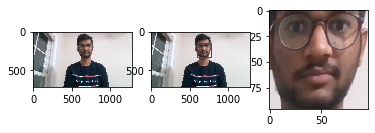

In [754]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[295].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [755]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [756]:
from tensorflow.keras.preprocessing import image
embedded = np.zeros((metadata.shape[0], 128))
_IMAGE_NET_TARGET_SIZE = (96, 96)
for i, m in enumerate(metadata):
    img_org = image.load_img(m.image_path(), target_size=_IMAGE_NET_TARGET_SIZE)
    #plt.imshow(img_org)
    #img_align = align_image(img_org)
    
    # scale RGB values to interval [0,1]
    img_vec=image.img_to_array(img_org)
    #img_vec = (img_align / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img_vec, axis=0))[0]
    print(embedded[i])

    

[-0.0390201   0.13896123 -0.05446754 -0.03697648  0.0296265   0.07060745
 -0.06959666 -0.00061234 -0.03923131  0.03208355  0.08185361  0.00324002
  0.11214606  0.06966278  0.06297504  0.01487259  0.04345585 -0.06267546
 -0.07776067  0.19084977 -0.00470603 -0.09430563  0.0852127   0.09615275
 -0.04278613 -0.01977827 -0.04882668 -0.01284147  0.05516696 -0.01972081
  0.08784267  0.0767428   0.07389053  0.08538071 -0.11602435  0.22220081
  0.05441594  0.16323081 -0.12132252  0.03953618  0.02509393 -0.02419755
 -0.00684181 -0.03011952 -0.09721751  0.03243119  0.17243375  0.04700486
 -0.10097475  0.08663756 -0.08484278  0.00528046 -0.13878764  0.02194973
  0.12556152  0.06980462 -0.12564473  0.08918602  0.0110857  -0.07107322
 -0.20439313  0.01290434  0.10584641 -0.20719467  0.06002532  0.06782402
  0.04725312  0.06655239 -0.11922768  0.08432578  0.03212279  0.04874745
 -0.04194647  0.09069904  0.18279549 -0.00193126  0.02597116  0.13780938
  0.01777106 -0.08923867 -0.08644885  0.03938056 -0

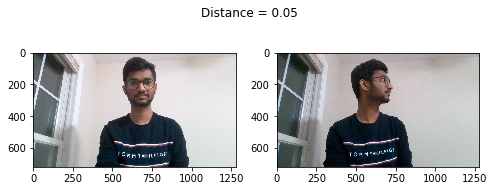

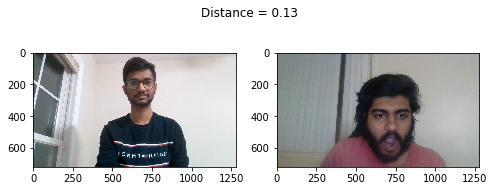

In [757]:
def distance(emb1, emb2):
    return np.sum(np.square(emb2 - emb1))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(295, 296)
show_pair(295, 290)

### Distance threshold

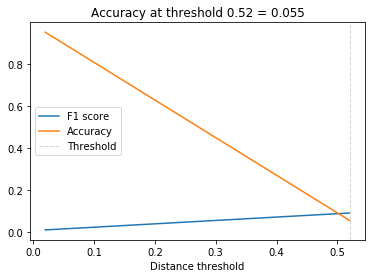

In [766]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.02, 1.0, 0.5)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();



### Face recognition

In [701]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 1 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.7234726688102894, SVM accuracy = 0.5594855305466238


In [705]:

teams=np.array([[2,15,31],[53,63,79],[95,111,132],[144,161],[172,183,200],[215,231,247],[263,283,295]])

Group_ID= int(input())
ip_idx=teams[Group_ID-1,]
print(ip_idx)

7
[263, 283, 295]


In [706]:
final_images = []
num = len(metadata)

for i in range(0,len(ip_idx)):
    
    example = ip_idx[i]
    for j in range(0,num):
        result = distance(embedded[example],embedded[j])
        if(result<thresholds[0]):
            final_images.append(j)
        

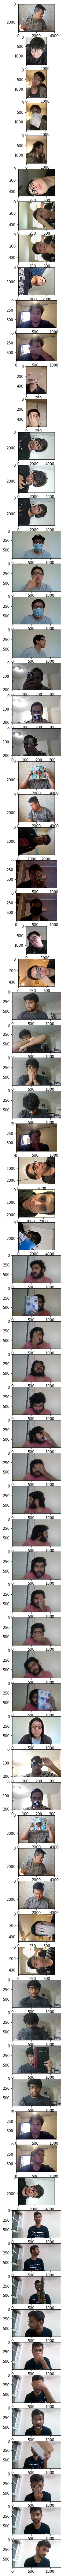

In [707]:
columns=1
rows =np.int32((len(final_images))/columns)
fig = plt.figure(figsize=(128,128))
for i in range(1,columns*rows+1):
    j=final_images[i-1]
    img= image.load_img(metadata[j].image_path())
    fig.add_subplot(rows,columns,i)
    plt.imshow(img)
plt.show()    



In [764]:
num = len(metadata)
no_groups = 7
groups = np.array([[0,46],[47,94],[95,142],[143,166],[167,214],[215,262],[263,310]])
precision = 0
recall = 0
for id in range(0,no_groups):
    group_range = groups[id]
    final_images = []
    ip_idx = teams[id]
    
    for i in range(0,len(ip_idx)):
    
        example = ip_idx[i]
        for j in range(0,num):
            result = distance(embedded[example],embedded[j])
            if(result<0.07):
                final_images.append(j)
    no_recog_img = len(final_images)
    no_corecog_img = 0
    no_actual_img = group_range[1] - group_range[0]
    for i in range(0,no_recog_img):
        if(group_range[0] <= final_images[i] <= group_range[1]):
            no_corecog_img += 1
    precision += (no_corecog_img/no_recog_img)
    recall += (no_corecog_img/no_actual_img)
    del final_images[:]
    #print(id+1)
    #print(precision)
    #print(recall)
avg_precision = precision/no_groups
avg_recall = recall/no_groups

print(avg_precision)
print(avg_recall)

0.2825068393101085
0.4331967754724462
